# Notes

Scotland changed the threshold from 98% to 95% in September 2014:
https://www.isdscotland.org/health-topics/waiting-times/Supporting-Documentation/National-Standards.asp#:~:text=The%20first%20target%20milestone%20was,Scottish%20Government%20and%20NHS%20Boards.

95% CI calculated using 10000 bootstrap runs; code taken from:
https://stackoverflow.com/questions/29481134/how-are-the-error-bands-in-seaborn-tsplot-calculated

dataset was downloaded on 05/04/2022 from:
https://publichealthscotland.scot/publications/ae-activity-and-waiting-times/ae-activity-and-waiting-times-month-ending-31-december-2021

## Ethical/privacy issues
No single patient data is present, all data is agglomerated by both hospital and month. We know of no ethical or privacy conflicts.

# Data Cleaning

In [23]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
plt.rcParams['figure.dpi'] = 200
plt.rc('axes', titlesize=12, labelsize=12)

In [24]:
def format_graph(ax, /, *, mode='y', xlabel='', ylabel='', title=''):
    # graphs with multiple years
    if mode == 'y':
        # creates proper x-axis ticks formatting (tick in January of year)
        ax.set_xticks(ax.get_xticks()[6::12])
        ax.set_xticklabels([f'20{str(s).zfill(2)}' if not s % 2 else '' for s in range(8, 22)])

    # graphs within 1 year
    elif mode == 'm':
        ax.set_xticks([m for m in range(1, 13)])
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # graph labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # set title
    ax.set_title(title)

In [25]:
def get_raw_data():
    return pd.read_csv(os.path.join(os.getcwd(), 'data', 'ae_activity_waiting_times_feb2022-data.csv'))

In [26]:
def get_data():
    raw_data = get_raw_data()

    # split date into month and year columns
    dates = raw_data['Data_Month_Date'].apply(lambda s: tuple(s.split(sep='-'))).apply(pd.Series)
    dates.columns = ['month', 'year']

    # drop duplicate columns
    data = dates.join(raw_data).drop(columns=['Data_Month_Date', 'Country',
                                              'Number_of_Attendances_Epi', 'Number_Meeting_Target_epi'])

    # rename columns
    data = data.rename(columns={'Number_Of_Attendances_agg':'total',
                                'Number_Meeting_Target_agg':'under4h',
                                'Attendance_greater_8hrs':'under12h',
                                'Attendances_greater_12hrs':'over12h',
                                'Discharge_destination_admission_to_same':'discharge_same',
                                'Discharge_destination_residence':'discharge_residence',
                                'Discharge_destination_transfer':'discharge_transfer',
                                'Discharge_destination_other_spec':'discharge_other',
                                'Discharge_destination_unknown':'discharge_unknown',
                                'HB_Treatment_Description':'area',
                                'Treatment_Location_Code':'location_code',
                                'Treatment_Location_Name':'location_name',
                                'ED_MIU':'type'})

    # calculate 8-12h column -> overlap to bins
    data['under12h'] = data['under12h'] - data['over12h']
    # calculate 4-8h column
    data['under8h'] = data['total'] - (data['under4h'] + data['under12h'] + data['over12h'])

    # rearrange columns
    cols = data.columns.tolist()
    data = data[cols[:8] + [cols[-1]] + cols[-3:-1] + cols[8:-3]]

    # month to numeric
    data['month'] = data['month'].apply(lambda s: {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                                                   'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}[s])
    # year to integers
    data['year'] = data['year'].apply(int)

    # make year-month column
    data['year_month'] = data['year'].apply(lambda s: str(s).zfill(2)) + \
                         data['month'].apply(lambda s: str(s).zfill(2))

    # calculate compliance
    data['compliance'] = data['total'] * 0.95 <= data['under4h']
    data['compliance'][data['year_month'] < '1409'] = \
        data['total'][data['year_month'] < '1409'] * 0.98 <= data['under4h'][data['year_month'] < '1409']
    data['compliance_frac'] = data['under4h'] / data['total']

    return raw_data, data

In [ ]:
raw_data, data = get_data()

In [28]:
raw_data

Data_Month_Date       Country HB_Treatment_Description  \
0              Jul-07  NHS Scotland     NHS Ayrshire & Arran   
1              Jul-07  NHS Scotland     NHS Ayrshire & Arran   
2              Jul-07  NHS Scotland     NHS Ayrshire & Arran   
3              Jul-07  NHS Scotland     NHS Ayrshire & Arran   
4              Jul-07  NHS Scotland              NHS Borders   
...               ...           ...                      ...   
15466          Dec-21  NHS Scotland              NHS Tayside   
15467          Dec-21  NHS Scotland              NHS Tayside   
15468          Dec-21  NHS Scotland        NHS Western Isles   
15469          Dec-21  NHS Scotland        NHS Western Isles   
15470          Dec-21  NHS Scotland        NHS Western Isles   

      Treatment_Location_Code                      Treatment_Location_Name  \
0                       A101H                  Arran War Memorial Hospital   
1                       A111H          University Hospital Crosshouse - ED   
2                       A207H                    Davidson Cottage Hospital   
3                       A210H                 University Hospital Ayr - ED   
4                       B103H                     Knoll Community Hospital   
...                       ...                                          ...   
15466                   T304H                           Arbroath Infirmary   
15467                   T319H  Whitehills Health And Community Care Centre   
15468                   W106H                        St Brendan's Hospital   
15469                   W107H                  Western Isles Hospital - ED   
15470                   W108H                        Uist & Barra Hospital   

          ED_MIU  Number_Of_Attendances_agg  Number_of_Attendances_Epi  \
0      MIU/Other                        252                        NaN   
1             ED                       5414                     5414.0   
2      MIU/Other                         92                        NaN   
3             ED                       3530                     3530.0   
4      MIU/Other                         20                        NaN   
...          ...                        ...                        ...   
15466  MIU/Other                        473                      473.0   
15467  MIU/Other                        227                      227.0   
15468  MIU/Other                         41                        NaN   
15469         ED                        325                      325.0   
15470  MIU/Other                         69                       69.0   

       Number_Meeting_Target_agg  Number_Meeting_Target_epi  \
0                            252                        NaN   
1                           5290                     5290.0   
2                             92                        NaN   
3                           3355                     3355.0   
4                             20                        NaN   
...                          ...                        ...   
15466                        473                      473.0   
15467                        227                      227.0   
15468                         41                        NaN   
15469                        313                      313.0   
15470                         69                       69.0   

       Discharge_destination_admission_to_same  \
0                                          NaN   
1                                       1985.0   
2                                          NaN   
3                                        106.0   
4                                          NaN   
...                                        ...   
15466                                      0.0   
15467                                      0.0   
15468                                      NaN   
15469                                     94.0   
15470                                      6.0   

       Discharge_destination_other_spec  Discharge_de

In [29]:
data

month  year                  area location_code  \
0          7     7  NHS Ayrshire & Arran         A101H   
1          7     7  NHS Ayrshire & Arran         A111H   
2          7     7  NHS Ayrshire & Arran         A207H   
3          7     7  NHS Ayrshire & Arran         A210H   
4          7     7           NHS Borders         B103H   
...      ...   ...                   ...           ...   
15466     12    21           NHS Tayside         T304H   
15467     12    21           NHS Tayside         T319H   
15468     12    21     NHS Western Isles         W106H   
15469     12    21     NHS Western Isles         W107H   
15470     12    21     NHS Western Isles         W108H   

                                     location_name       type  total  under4h  \
0                      Arran War Memorial Hospital  MIU/Other    252      252   
1              University Hospital Crosshouse - ED         ED   5414     5290   
2                        Davidson Cottage Hospital  MIU/Other     92       92   
3                     University Hospital Ayr - ED         ED   3530     3355   
4                         Knoll Community Hospital  MIU/Other     20       20   
...                                            ...        ...    ...      ...   
15466                           Arbroath Infirmary  MIU/Other    473      473   
15467  Whitehills Health And Community Care Centre  MIU/Other    227      227   
15468                        St Brendan's Hospital  MIU/Other     41       41   
15469                  Western Isles Hospital - ED         ED    325      313   
15470                        Uist & Barra Hospital  MIU/Other     69       69   

       under8h  under12h  over12h  discharge_same  discharge_other  \
0          NaN       NaN      NaN             NaN              NaN   
1         98.0       2.0     24.0          1985.0             11.0   
2          NaN       NaN      NaN             NaN              NaN   
3        172.0       2.0      1.0           106.0              0.0   
4          NaN       NaN      NaN             NaN              NaN   
...        ...       ...      ...             ...              ...   
15466      0.0       0.0      0.0             0.0              0.0   
15467      0.0       0.0      0.0             0.0              0.0   
15468      NaN       NaN      NaN             NaN              NaN   
15469     11.0       1.0      0.0            94.0              1.0   
15470      0.0       0.0      0.0             6.0              0.0   

       discharge_residence  discharge_transfer  discharge_unknown year_month  \
0                      NaN                 NaN                NaN       0707   
1                   3374.0                44.0                0.0       0707   
2                      NaN                 NaN                NaN       0707   
3                   3369.0                 8.0               47.0       0707   
4                      NaN                 NaN                NaN       0707   
...                    ...                 ...                ...        ...   
15466                422.0                48.0                3.0       2112   
15467                209.0                18.0                0.0       2112   
15468                  NaN                 NaN                NaN       2112   
15469                227.0                 2.0                1.0       2112   
15470                 63.0                 0.0                0.0       2112   

      compliance  compliance_frac  
0           True         1.000000  
1          False         0.977096  
2           True         1.000000  
3          False         0.950425  
4           True         1.000000  
...          ...              ...  
15466       True         1.000000  
15467       True         1.000000  
15468       True         1.000000  
15469       True         0.963077  
15470       True         1.000000  

[15471 rows x 19 columns]

# Overview graphs

<AxesSubplot:>

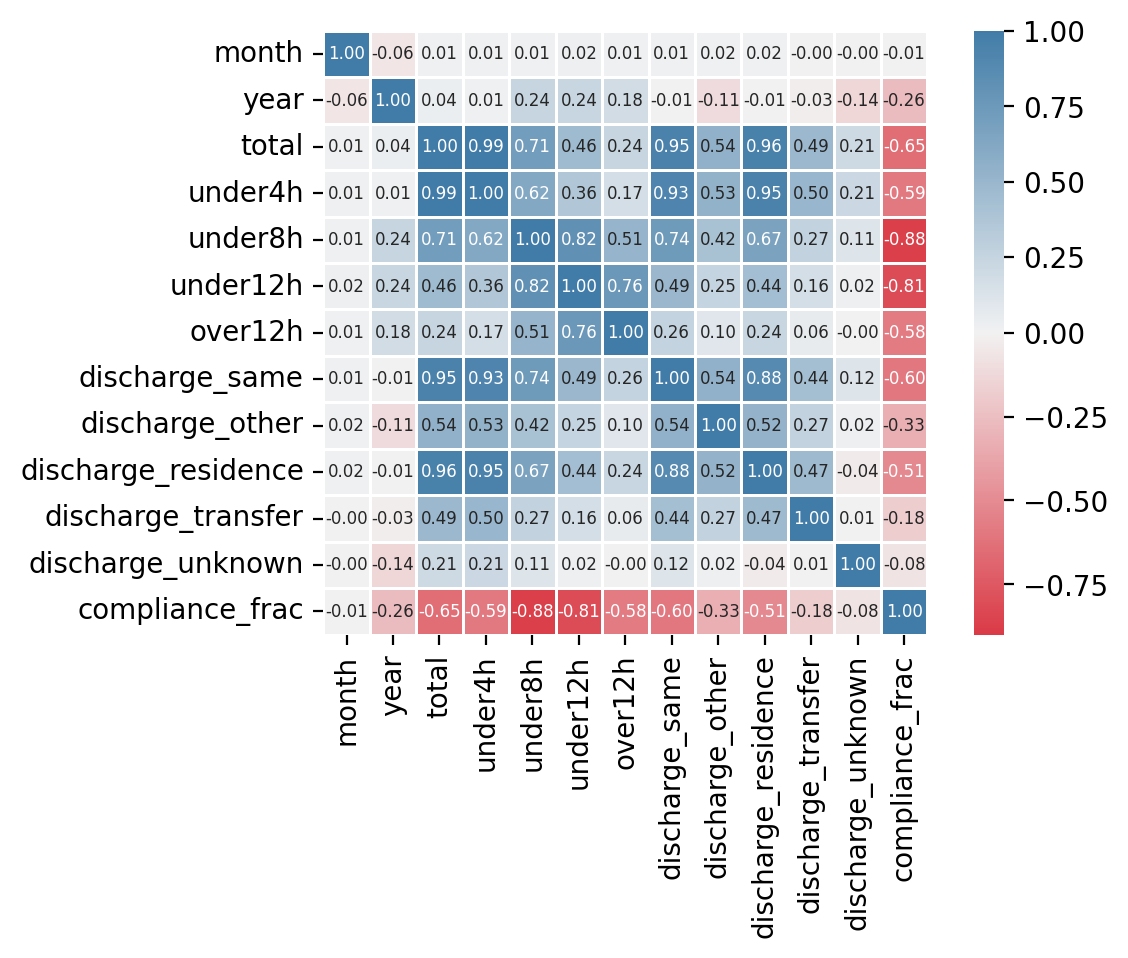

In [31]:
sns.heatmap(data.corr(),
            square=True,
            annot=True,
            annot_kws={'fontsize':6},
            linewidth=0.5,
            fmt='.2f',
            cmap=sns.diverging_palette(10, 240, as_cmap=True),
            norm=TwoSlopeNorm(vmax=1, vmin=-0.9, vcenter=0))

# Export Graphs

12 * 100 * ols_sum.params[1]=-0.20545878375168827, ols_sum.rsquared=0.588670344522564
12 * 100 * ols_ed.params[1]=-0.5741956855271269, ols_ed.rsquared=0.6403853730699527
12 * 100 * ols_miu.params[1]=-0.02419606400941875, ols_miu.rsquared=0.25728822046536415


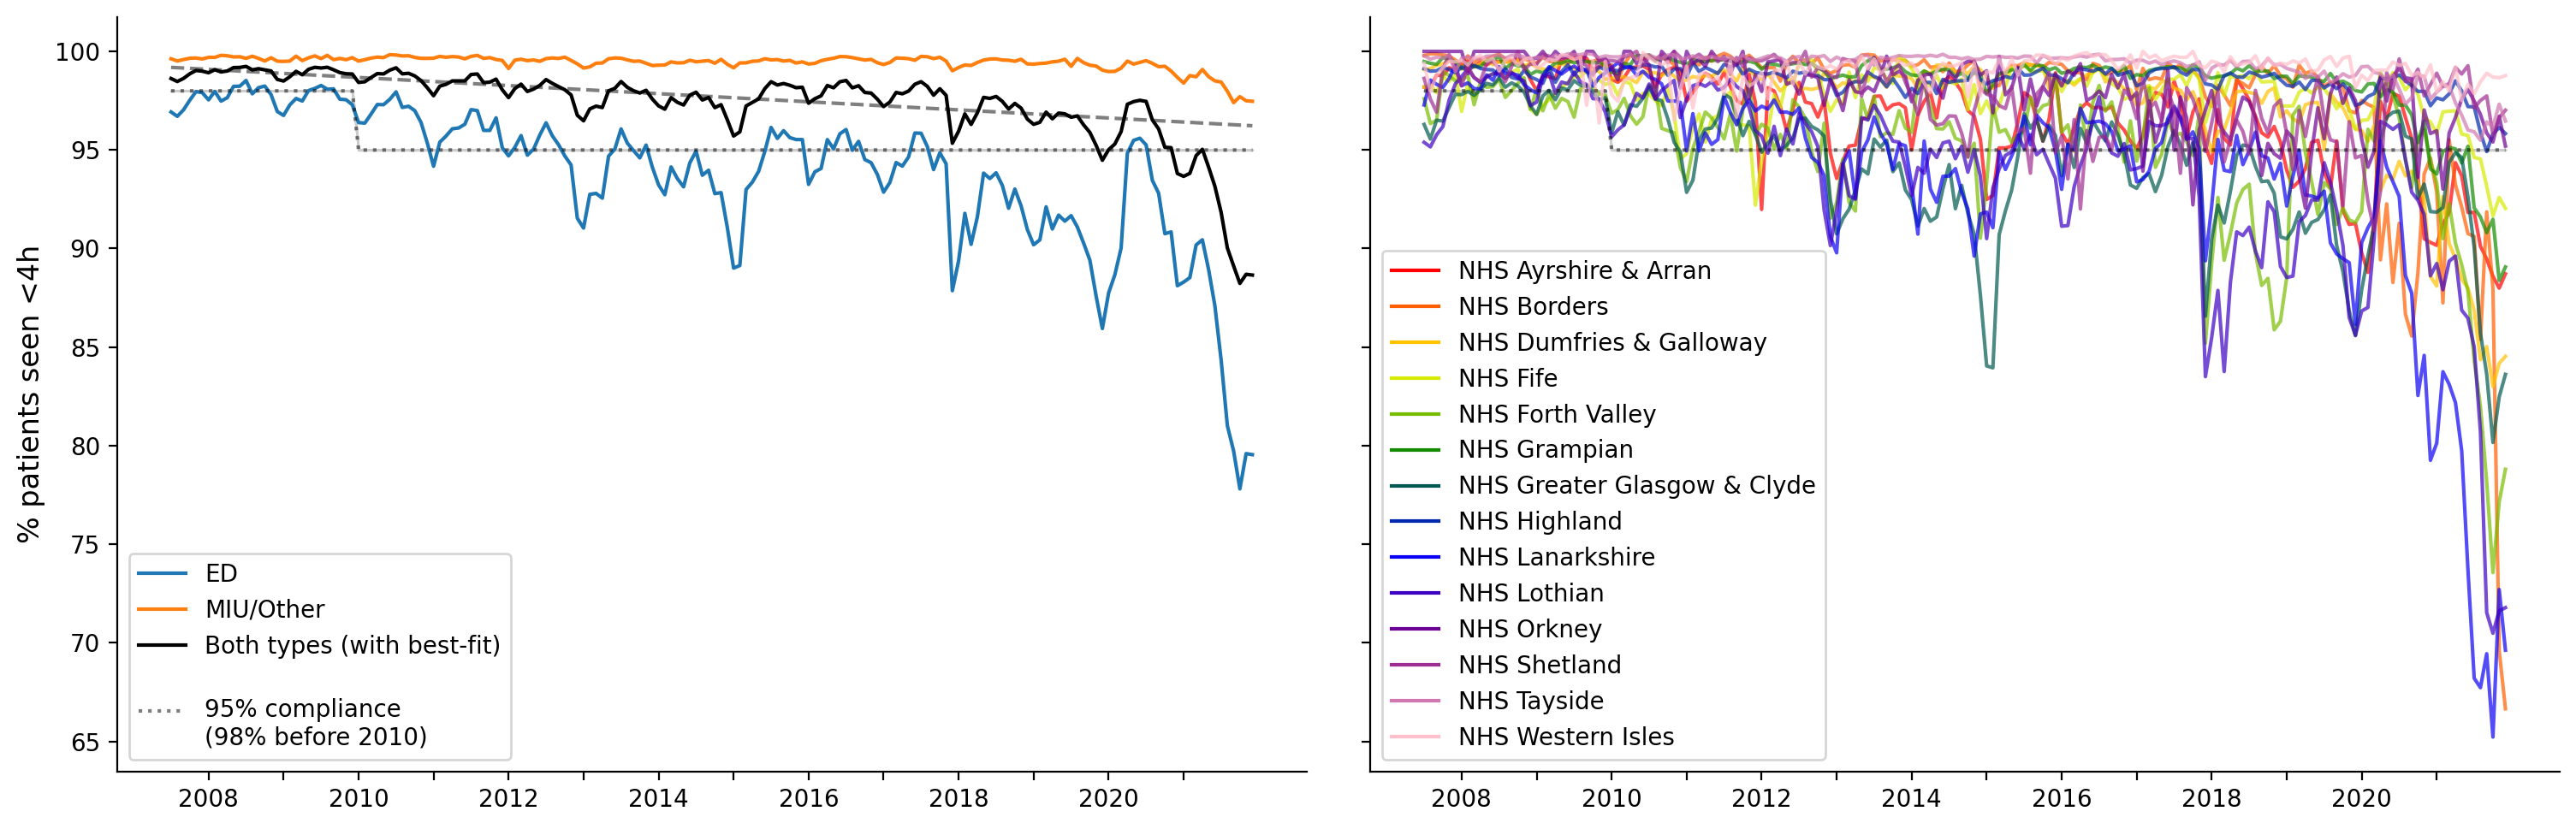

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)
fig.tight_layout()

# plot 1 data
df1 = data.groupby(['type', 'year_month']).mean().reset_index() \
          .sort_values(['year_month', 'type']).reset_index()
df3 = data.groupby(['year_month']).mean().reset_index() \
          .sort_values(['year_month']).reset_index()

# plot 1 OLS
ols_ed = smf.ols('compliance_frac ~ index',
                  data=df1[(df1['type'] == 'ED') & (df1['year_month'] <= '2003')]
                  ).fit()
ols_miu = smf.ols('compliance_frac ~ index',
                  data=df1[(df1['type'] == 'MIU/Other') & (df1['year_month'] <= '2003')]
                  ).fit()
ols_sum = smf.ols('compliance_frac ~ index',
                  data=df3[df3['year_month'] <= '2003']).fit()

# plot 1
sns.lineplot(data=df1,
             x='year_month',
             y=100 * df1['compliance_frac'],
             hue='type',
             ax=ax1)
sns.lineplot(data=df3,
             x='year_month',
             y=100 * df3['compliance_frac'],
             label='Both types (with best-fit)',
             color='black',
             ax=ax1)
sns.lineplot(data=df3,
             x='year_month',
             y=100 * ols_sum.predict(df3['index']),
             color='black',
             linestyle='dashed',
             alpha=0.5,
             ax=ax1)
sns.lineplot(data=df1,
             x='year_month',
             y=[98] * 60 + [95] * 288,
             label='\n95% compliance\n(98% before 2010)',
             color='black',
             linestyle='dotted',
             alpha=0.5,
             ax=ax1)
format_graph(ax1, ylabel='% patients seen <4h') #, title='Percentage of patients seen <4h (mean)')

# plot 2
df2 = data.groupby(['year_month', 'area']).mean()
sns.lineplot(data=df2,
             x='year_month',
             y=100 * df2['compliance_frac'],
             hue='area',
             palette=sns.blend_palette(['red', 'yellow', 'green', 'blue', 'purple', 'pink'], n_colors=14),
             alpha=0.7,
             ax=ax2)
sns.lineplot(data=df2,
             x='year_month',
             y=[98] * (30*14) + [95] * (144*14),
             color='black',
             linestyle='dotted',
             alpha=0.5,
             ax=ax2)
format_graph(ax2, ylabel='% patients seen') #, title='Percentage of patients seen <4h (mean by NHS board)')
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='lower left')

sns.despine(fig)

print(f'{12 * 100 * ols_sum.params[1]=}, {ols_sum.rsquared=}\n'
      f'{12 * 100 * ols_ed.params[1]=}, {ols_ed.rsquared=}\n'
      f'{12 * 100 * ols_miu.params[1]=}, {ols_miu.rsquared=}')

# Time Graphs

12 * 100 * ols_ed.params[1]=3430.781287135625, ols_ed.rsquared=0.26890326324013647
12 * 100 * ols_miu.params[1]=1232.61381608625, ols_miu.rsquared=0.6369892027120927


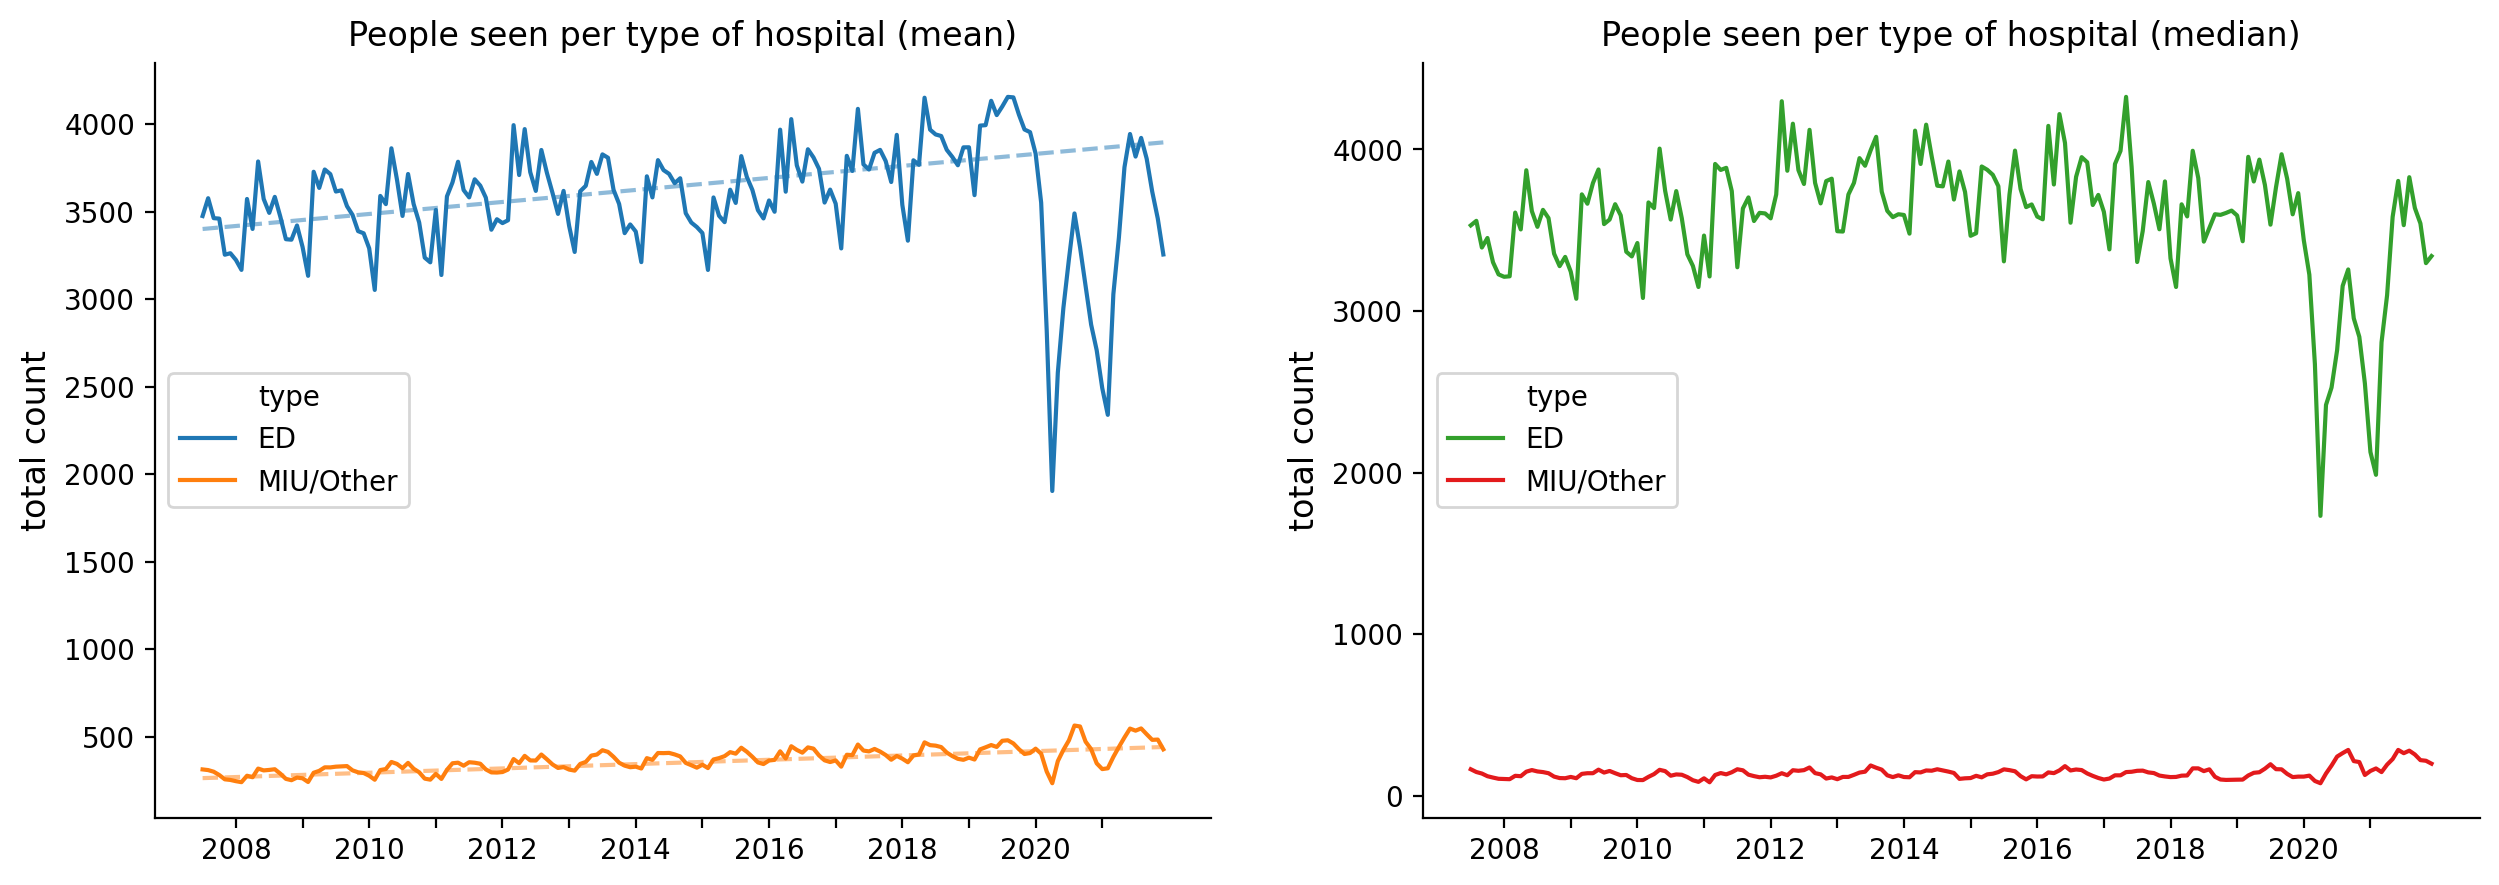

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

df1 = data.groupby(['type', 'year_month']).mean().reset_index().sort_values(['year_month', 'type']).reset_index()

# plot 1 OLS
ols_ed = smf.ols('total ~ index',
                 data=df1[(df1['type'] == 'ED') &(df1['year_month'] <= '2003')] #(df1['type'] == 'ED') &
                 ).fit()
ols_miu = smf.ols('total ~ index',
                  data=df1[(df1['type'] == 'MIU/Other') & (df1['year_month'] <= '2003')]
                  ).fit()

sns.lineplot(data=df1,
             x='year_month',
             y=ols_miu.predict(df1['index'])+75,#df1['index']
             color=sns.color_palette()[1],
             linestyle='dashed',
             alpha=0.5,
             ax=ax1,
             ci=None)

sns.lineplot(data=df1,
             x='year_month',
             y=ols_ed.predict(df1['index'])-255,
             color=sns.color_palette()[0],
             linestyle='dashed',
             alpha=0.5,
             ax=ax1,
             ci=None)

sns.lineplot(data=data.groupby(['type', 'year', 'year_month']).mean(),
             x='year_month',
             y='total',
             hue='type',
             ax=ax1)
format_graph(ax1, ylabel='total count', title='People seen per type of hospital (mean)')

sns.lineplot(data=data.groupby(['type', 'year', 'year_month']).median(),
             x='year_month',
             y='total',
             hue='type',
             palette=reversed(sns.color_palette('Paired_r')[3:5]),
             ax=ax2)
format_graph(ax2, ylabel='total count', title='People seen per type of hospital (median)')

sns.despine(fig)
print(
      f'{12 * 100 * ols_ed.params[1]=}, {ols_ed.rsquared=}\n'
      f'{12 * 100 * ols_miu.params[1]=}, {ols_miu.rsquared=}')

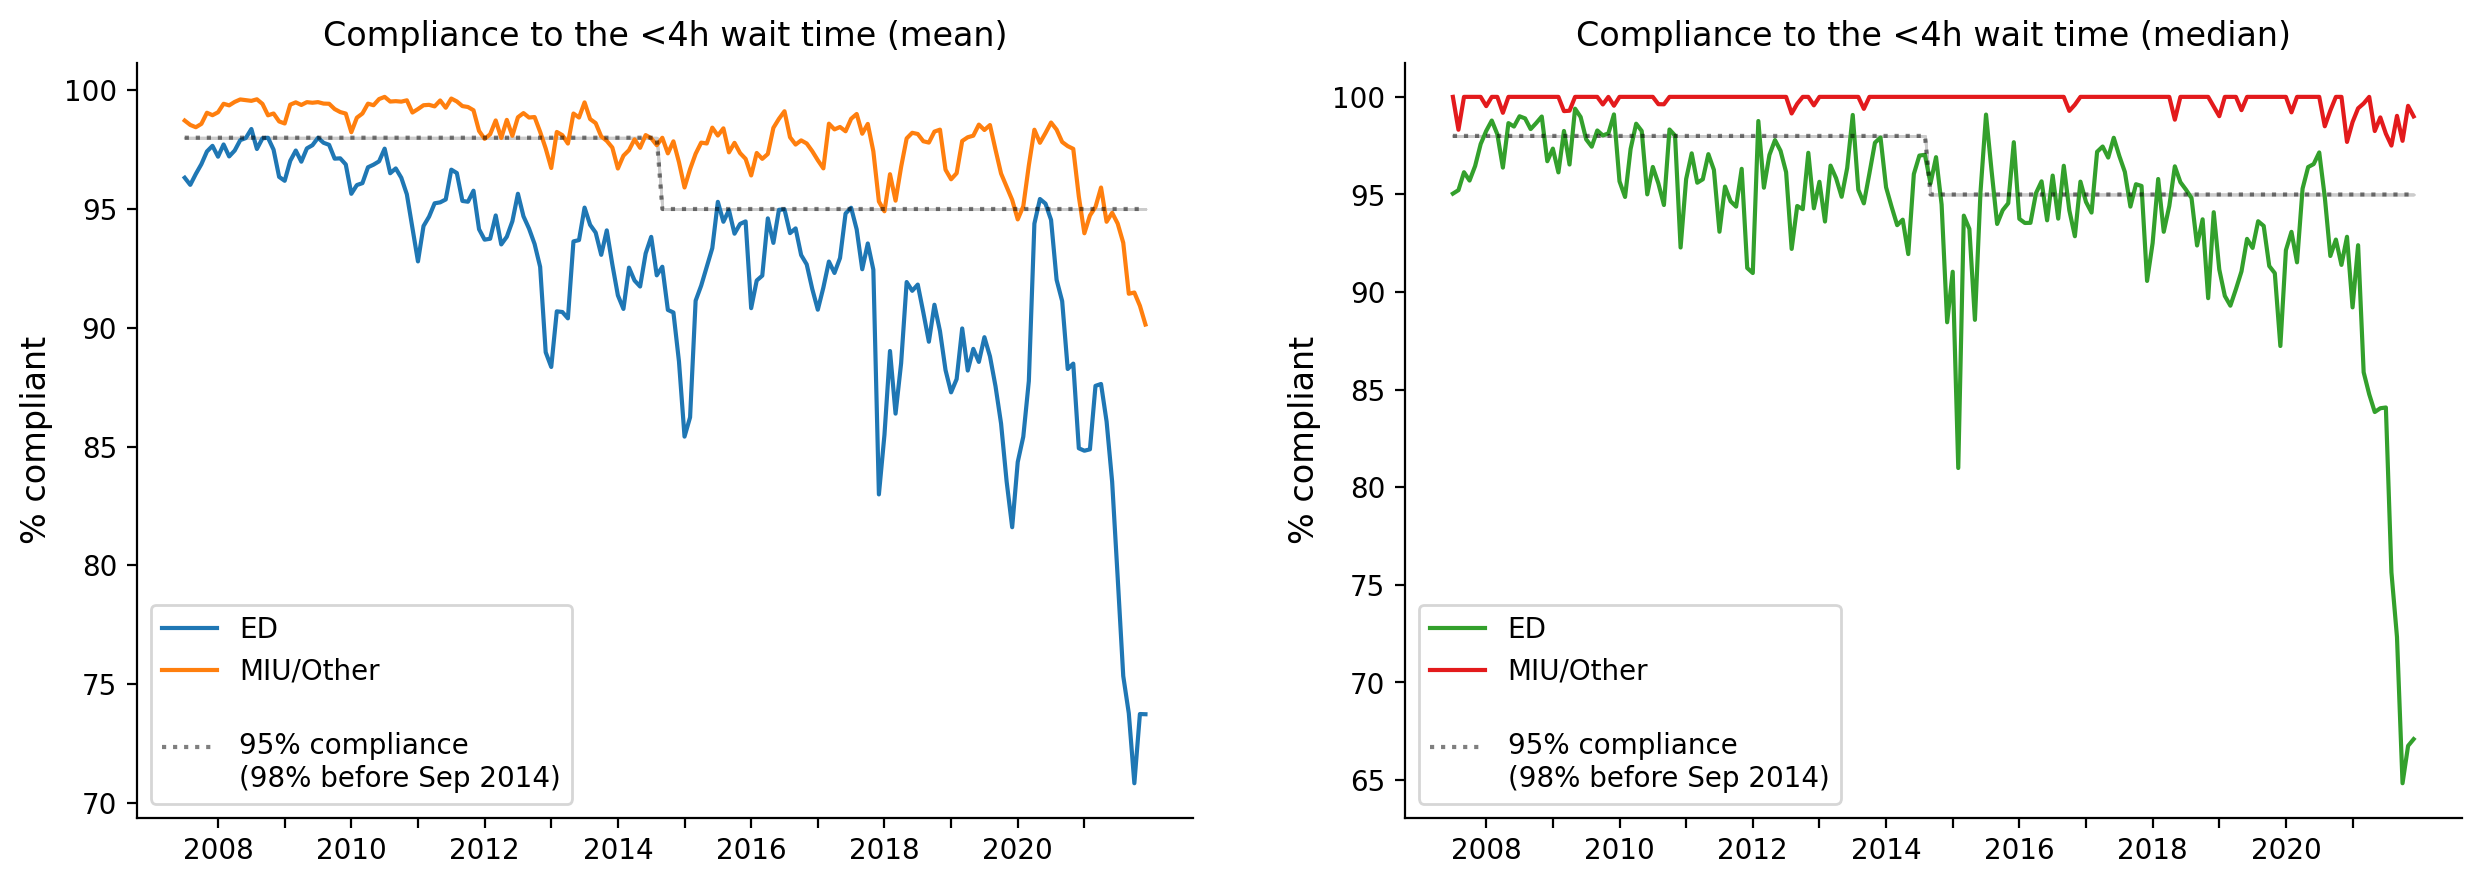

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# plot 1 data
df1 = data.groupby(['type', 'year_month']).mean()

# plot 1 OLS


# plot 1
sns.lineplot(data=df1,
             x='year_month',
             y=100 * df1['under4h'] / df1['total'],
             hue='type',
             ax=ax1)
sns.lineplot(data=df1,
             x='year_month',
             y=[98] * 86 + [95] * 88 + [98] * 86 + [95] * 88,
             label='\n95% compliance\n(98% before Sep 2014)',
             color='black',
             alpha=0.5,
             linestyle='dotted',
             ax=ax1)
format_graph(ax1, ylabel='% compliant', title='Compliance to the <4h wait time (mean)')

# plot 2
df2 = data.groupby(['type', 'year_month']).median()
sns.lineplot(data=df2,
             x='year_month',
             y=100 * df2['under4h'] / df2['total'],
             hue='type',
             palette=reversed(sns.color_palette('Paired_r')[3:5]),
             ax=ax2)
sns.lineplot(data=df2,
             x='year_month',
             y=[98] * 86 + [95] * 88 + [98] * 86 + [95] * 88,
             label='\n95% compliance\n(98% before Sep 2014)',
             color='black',
             alpha=0.5,
             linestyle='dotted',
             ax=ax2)
format_graph(ax2, ylabel='% compliant', title='Compliance to the <4h wait time (median)')

sns.despine(fig)

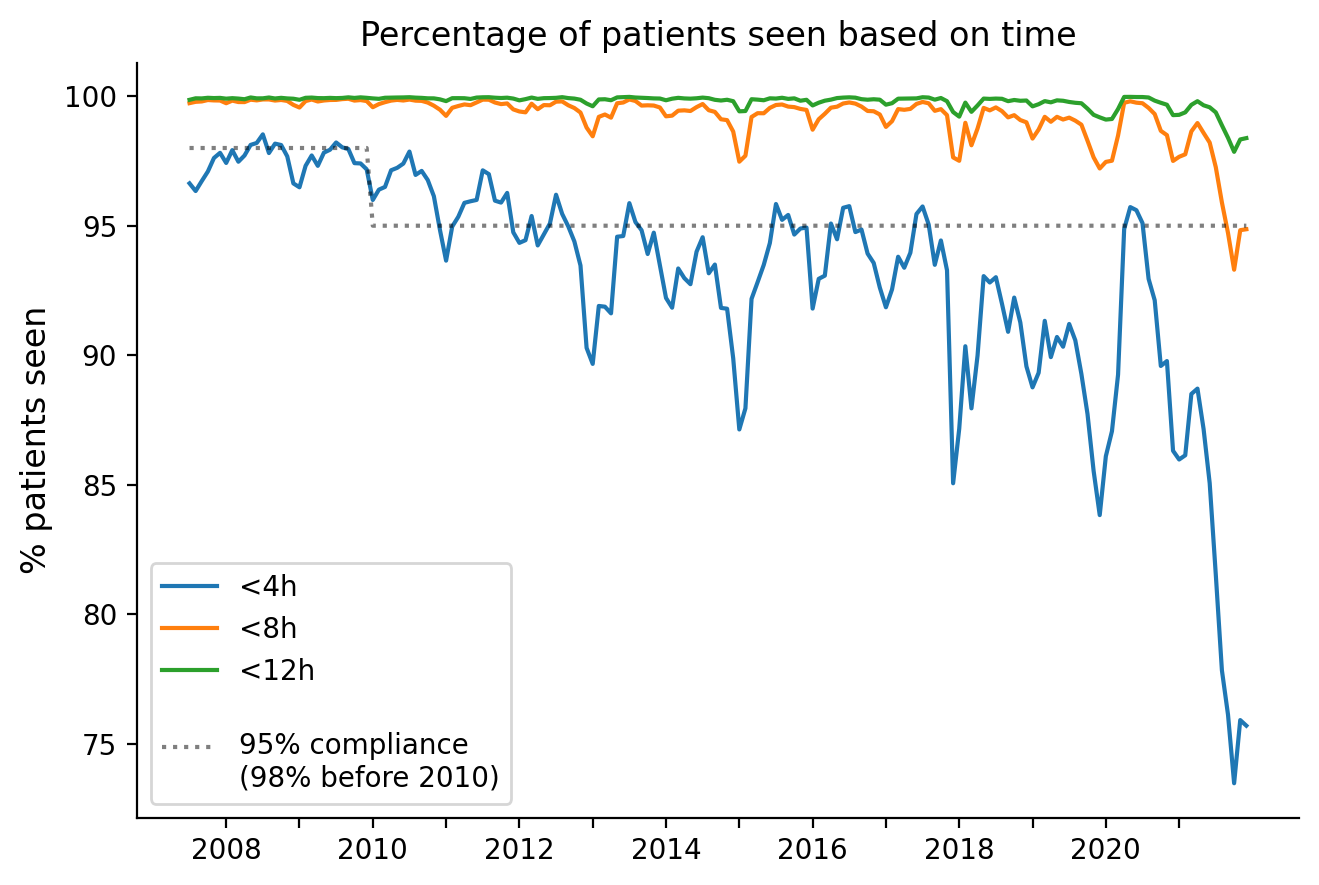

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

# plot 1
df = data.groupby('year_month').sum().reset_index()
sns.lineplot(data=df,
             x='year_month',
             y=100 * df['under4h'] / df['total'],
             label='<4h',
             ax=ax)
sns.lineplot(data=df,
             x='year_month',
             y=100 * (df['under4h'] + df['under8h']) / df['total'],
             label='<8h',
             ax=ax)
sns.lineplot(data=df,
             x='year_month',
             y=100 * (df['under4h'] + df['under8h'] + df['under12h']) / df['total'],
             label='<12h',
             ax=ax)
# plot 1 boundary
sns.lineplot(data=df,
             x='year_month',
             y=[98] * 30 + [95] * 144,
             label='\n95% compliance\n(98% before 2010)',
             color='black',
             alpha=0.5,
             linestyle='dotted',
             ax=ax)

format_graph(ax, ylabel='% patients seen', title='Percentage of patients seen based on time')

sns.despine(fig)

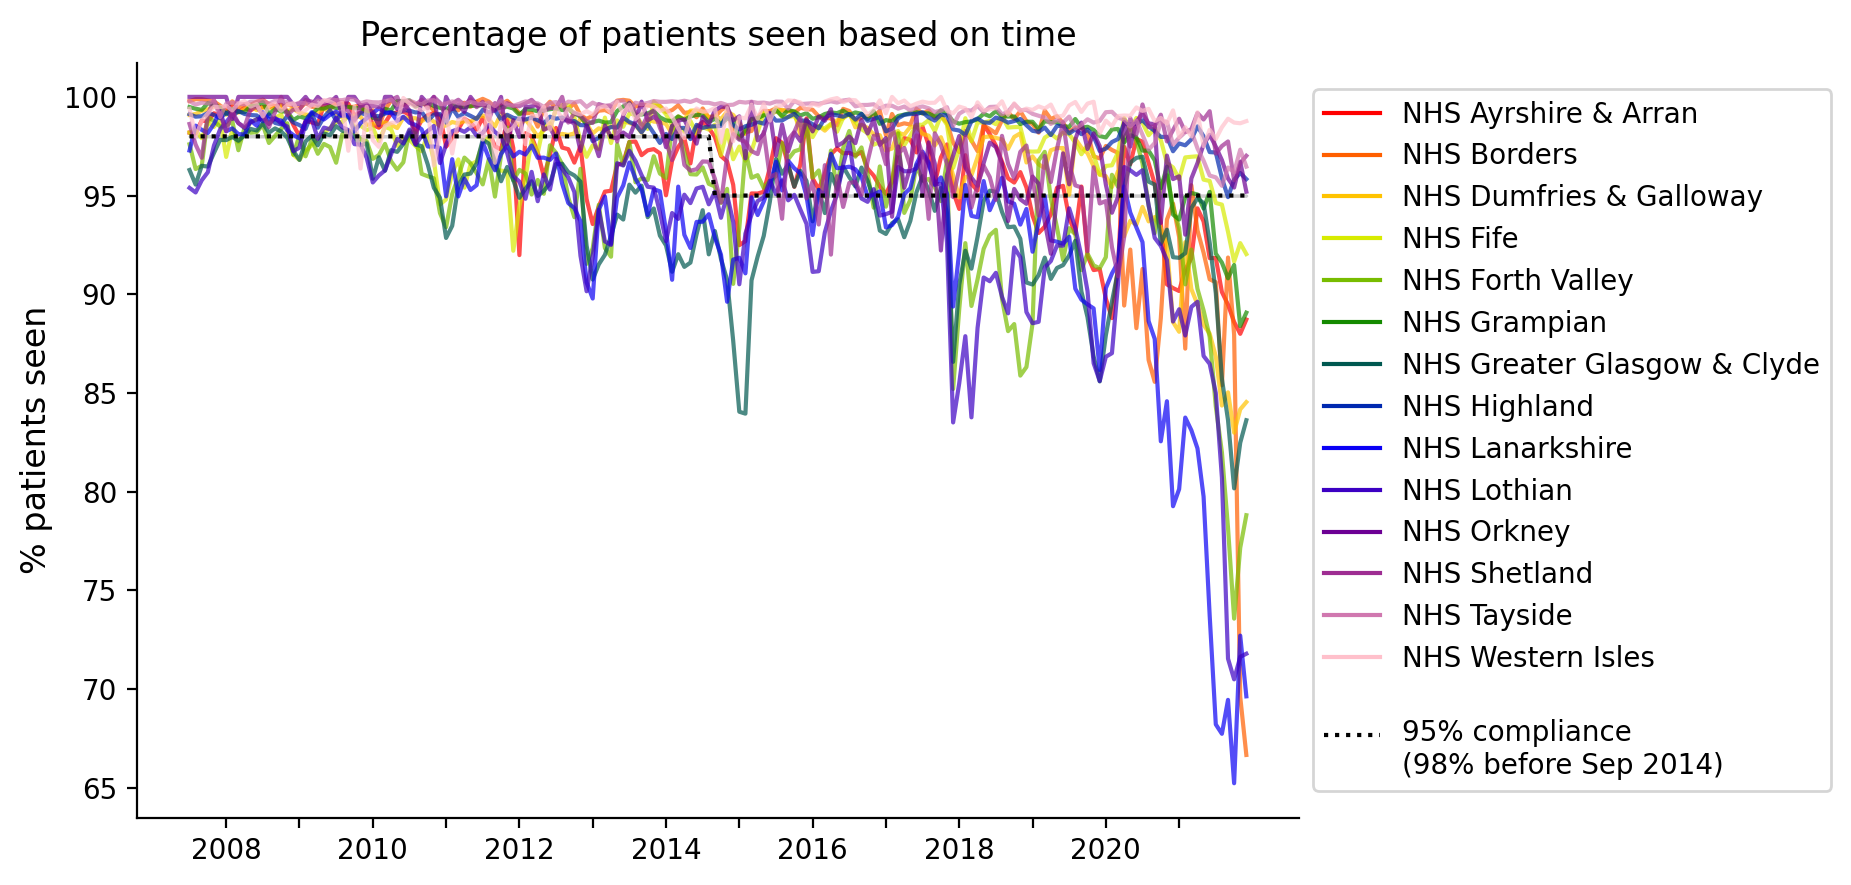

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

df = data.groupby(['year_month', 'area']).mean()
sns.lineplot(data=df,
             x='year_month',
             y=100 * df['compliance_frac'],
             hue='area',
             palette=sns.blend_palette(['red', 'yellow', 'green', 'blue', 'purple', 'pink'], n_colors=14),
             alpha=0.7,
             ax=ax)
sns.lineplot(data=df,
             x='year_month',
             y=[98] * (86*14) + [95] * (88*14),
             label='\n95% compliance\n(98% before Sep 2014)',
             color='black',
             linestyle='dotted',
             ax=ax)
format_graph(ax, ylabel='% patients seen', title='Percentage of patients seen based on time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine(fig)

In [37]:
data.groupby('year_month').mean().reset_index().reset_index()

index year_month  month  year        total      under4h     under8h  \
0        0       0707    7.0   7.0  1485.842697  1435.842697  105.000000   
1        1       0708    8.0   7.0  1521.191011  1465.494382  119.564103   
2        2       0709    9.0   7.0  1486.386364  1437.670455  103.128205   
3        3       0710   10.0   7.0  1460.269663  1417.808989   91.974359   
4        4       0711   11.0   7.0  1368.348315  1335.696629   69.435897   
..     ...        ...    ...   ...          ...          ...         ...   
169    169       2108    8.0  21.0  2128.953125  1657.046875  559.386364   
170    170       2109    9.0  21.0  2055.750000  1564.843750  568.976744   
171    171       2110   10.0  21.0  1973.571429  1450.079365  586.928571   
172    172       2111   11.0  21.0  1947.836066  1478.655738  535.095238   
173    173       2112   12.0  21.0  1818.590164  1376.622951  506.238095   

       under12h    over12h  discharge_same  discharge_other  \
0      4.358974   2.641026      742.743590        11.102564   
1      4.717949   0.641026      791.743590        12.230769   
2      3.923077   1.179487      772.487179        11.461538   
3      2.871795   0.307692      804.871795        13.923077   
4      2.820513   0.948718      765.717949         8.564103   
..          ...        ...             ...              ...   
169   92.227273  33.250000      742.295455         3.386364   
170  112.534884  46.441860      733.279070         3.279070   
171  134.738095  62.809524      760.785714         3.904762   
172   99.095238  46.523810      748.619048         3.976190   
173   92.928571  42.119048      731.880952         3.595238   

     discharge_residence  discharge_transfer  discharge_unknown  \
0            2180.589744           40.307692          96.897436   
1            2211.256410           43.692308          90.102564   
2            2146.025641           44.589744          90.846154   
3            2111.512821           41.717949          88.230769   
4            1979.333333           37.179487          90.871795   
..                   ...                 ...                ...   
169          2110.977273           48.090909          89.477273   
170          2102.046512           48.813953          89.488372   
171          1991.190476           50.595238          73.595238   
172          1890.500000           45.857143          68.476190   
173          1728.238095           45.690476          61.333333   

     compliance_frac  
0           0.986239  
1           0.984730  
2           0.986299  
3           0.988633  
4           0.990322  
..               ...  
169         0.900245  
170         0.891155  
171         0.882301  
172         0.886927  
173         0.886532  

[174 rows x 15 columns]

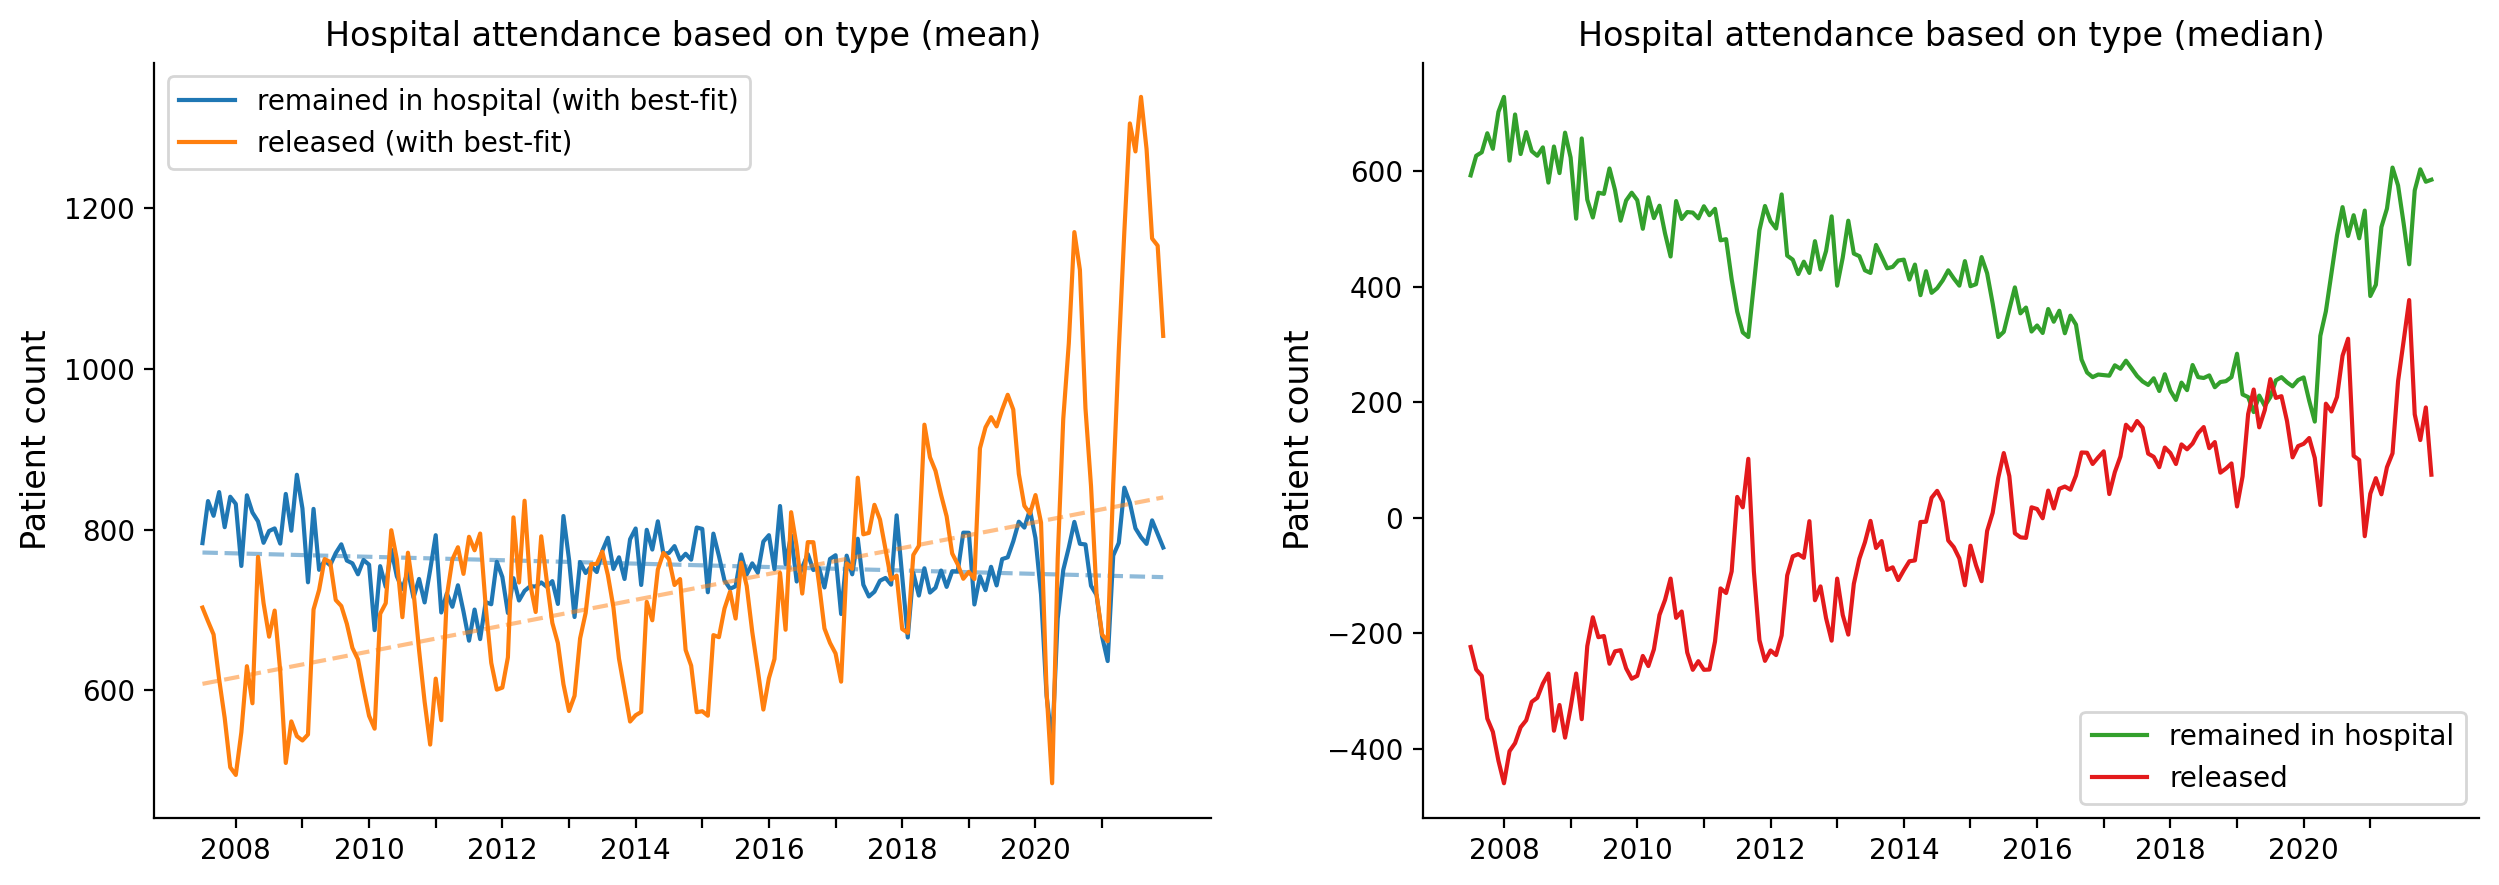

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# plot 1
df1 = data.groupby('year_month').mean().reset_index().reset_index()
df1['discharge_remain'] = df1['discharge_same'] + df1['discharge_transfer']
df1['discharge_leave'] = df1['total'] - (df1['discharge_same'] + df1['discharge_transfer'])

ols_remain = smf.ols('discharge_remain ~ index',
                     data=df1[df1['year_month'] < '2003']
                     ).fit()
ols_leave = smf.ols('discharge_leave ~ index',
                    data=df1[df1['year_month'] < '2003']
                    ).fit()

sns.lineplot(data=df1,
             x='year_month',
             y=df1['discharge_same'] + df1['discharge_transfer'],
             label='remained in hospital (with best-fit)',
             ax=ax1)
sns.lineplot(data=df1,
             x='year_month',
             y=ols_remain.predict(df1['index']),
             color=sns.color_palette()[0],
             linestyle='dashed',
             alpha=0.5,
             ax=ax1)

sns.lineplot(data=df1,
             x='year_month',
             y=df1['total'] - (df1['discharge_same'] + df1['discharge_transfer']),
             label='released (with best-fit)',
             ax=ax1)
sns.lineplot(data=df1,
             x='year_month',
             y=ols_leave.predict(df1['index']),
             color=sns.color_palette()[1],
             linestyle='dashed',
             alpha=0.5,
             ax=ax1)

format_graph(ax1, ylabel='Patient count', title='Hospital attendance based on type (mean)')

# plot 2
df2 = data.groupby('year_month').median()
sns.lineplot(data=df2,
             x='year_month',
             y=df2['discharge_same'] + df2['discharge_transfer'],
             label='remained in hospital',
             color=sns.color_palette('Paired_r')[4],
             ax=ax2)
sns.lineplot(data=df2,
             x='year_month',
             y=df2['total'] - (df2['discharge_same'] + df2['discharge_transfer']),
             label='released',
             color=sns.color_palette('Paired_r')[3],
             ax=ax2)
format_graph(ax2, ylabel='Patient count', title='Hospital attendance based on type (median)')

sns.despine(fig)

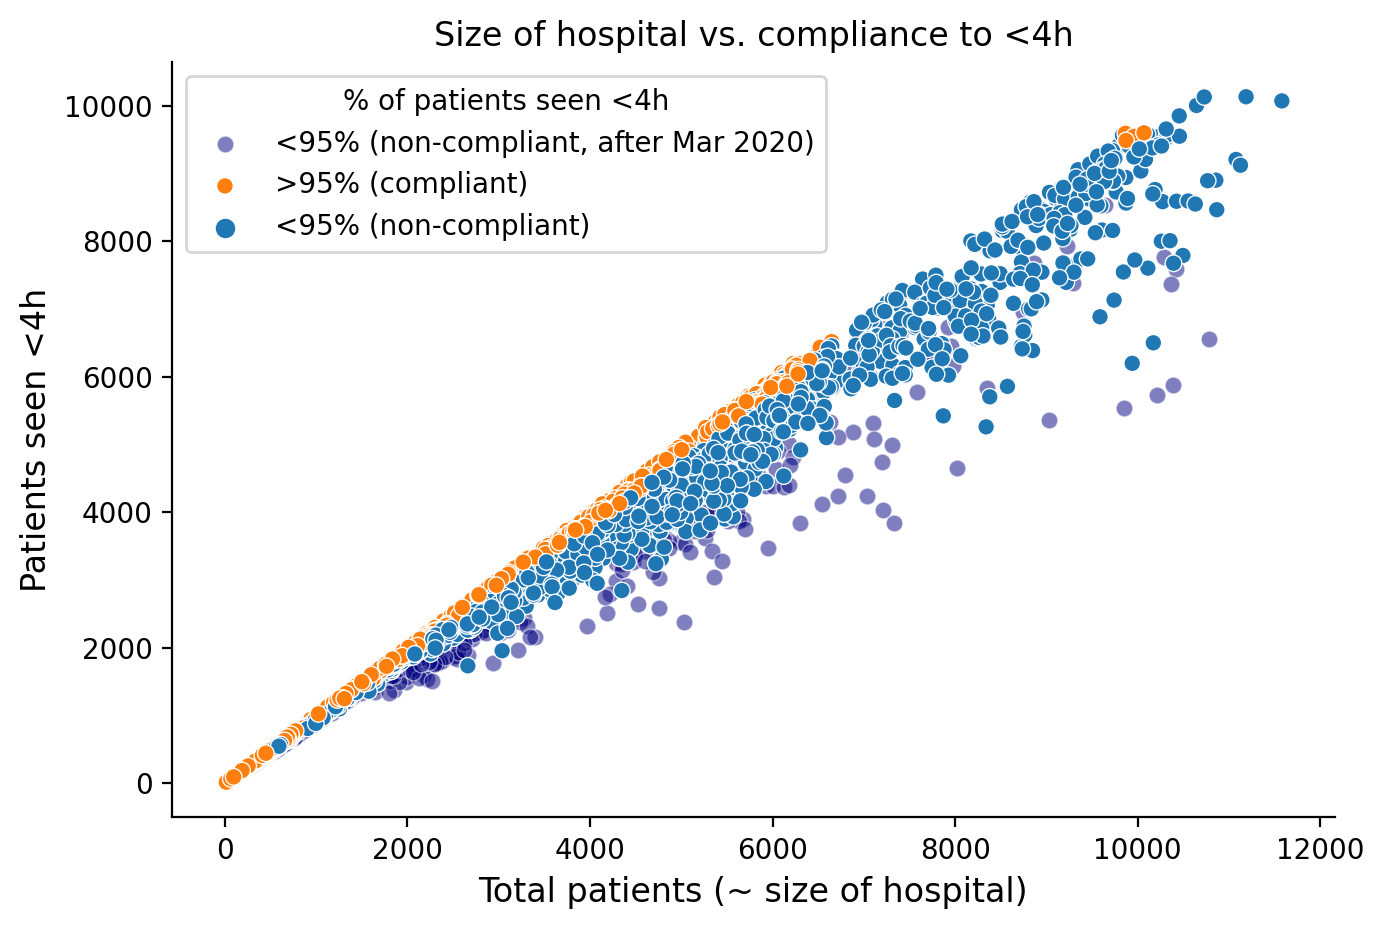

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

df = data.copy()
sns.scatterplot(data=df.loc[df['year_month'] >= '2003'],
                x='total',
                y='under4h',
                alpha=0.5,
                color='navy',
                ax=ax)
sns.scatterplot(data=df.loc[df['year_month'] < '2003'],
                x='total',
                y='under4h',
                hue='compliance',
                ax=ax)\
           .set(xlabel='Total patients (~ size of hospital)',
                ylabel='Patients seen <4h',
                title='Size of hospital vs. compliance to <4h')
plt.legend(title='% of patients seen <4h',
           labels=['<95% (non-compliant, after Mar 2020)',
                   '>95% (compliant)',
                   '<95% (non-compliant)'])

sns.despine(fig)

# Utility graphs

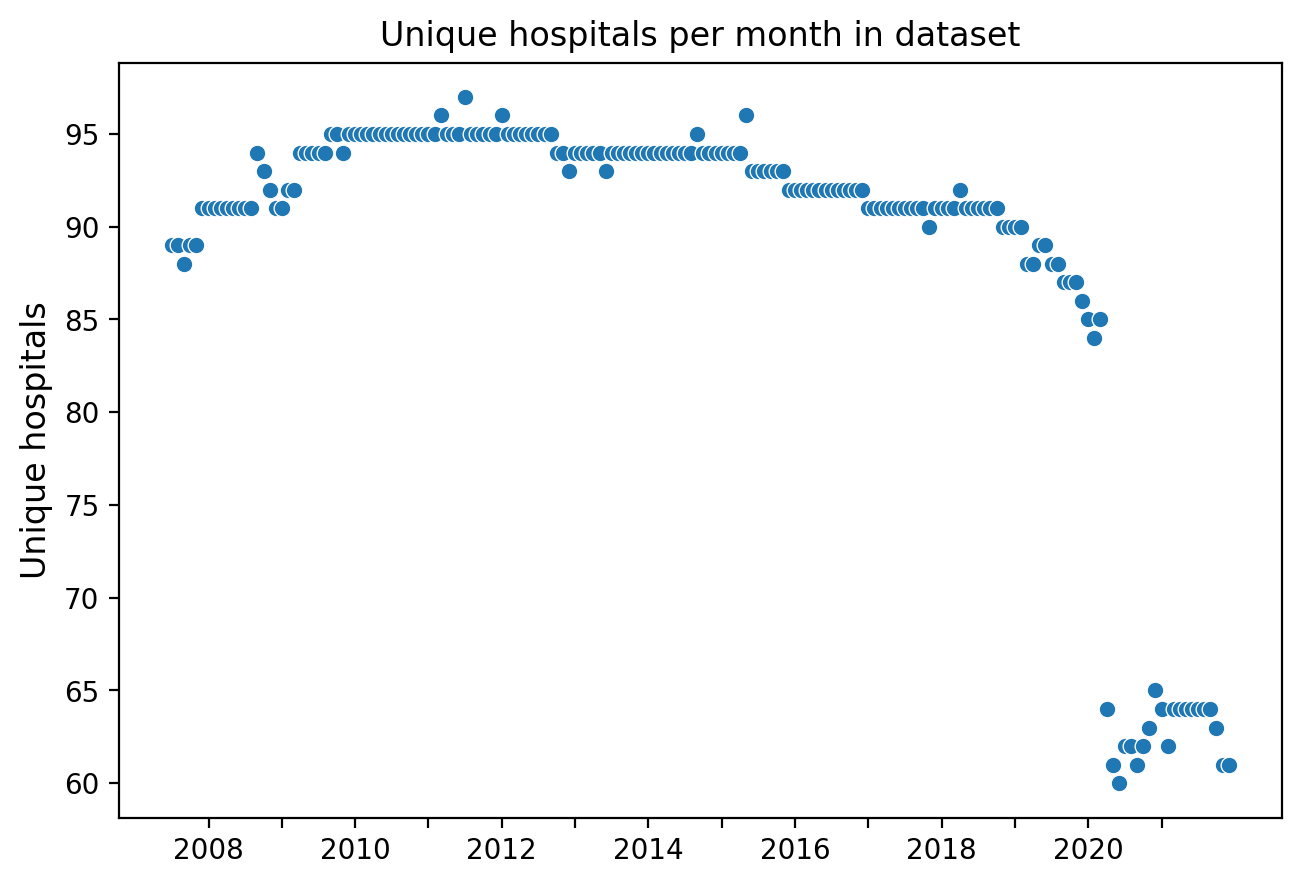

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

sns.scatterplot(data=data.groupby('year_month').nunique(),
                x='year_month',
                y='location_name',
                ax=ax)
format_graph(ax, ylabel='Unique hospitals', title='Unique hospitals per month in dataset')

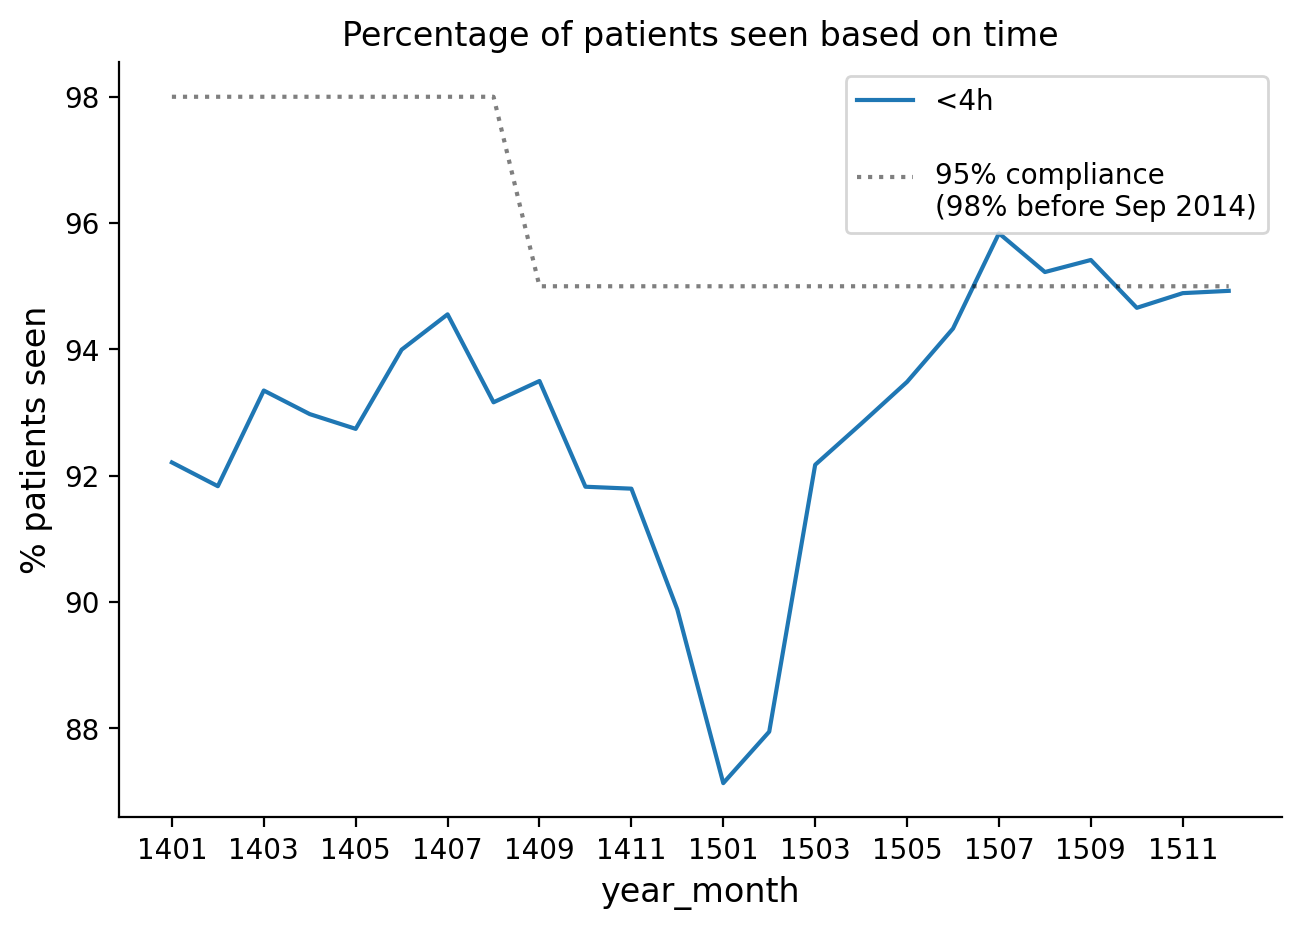

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

df = data.groupby('year_month').sum().reset_index()
df = df[(df['year_month'] >= '1401') & (df['year_month'] <= '1512')]

sns.lineplot(data=df,
             x='year_month',
             y=100 * df['under4h'] / df['total'],
             label='<4h',
             ax=ax)

sns.lineplot(data=df,
             x='year_month',
             y=[98] * 8 + [95] * 16,
             label='\n95% compliance\n(98% before Sep 2014)',
             color='black',
             alpha=0.5,
             linestyle='dotted',
             ax=ax)

ax.set_xticks(ax.get_xticks()[::2])
ax.set_ylabel('% patients seen')
ax.set_title('Percentage of patients seen based on time')

sns.despine(fig)

# Monthly graphs

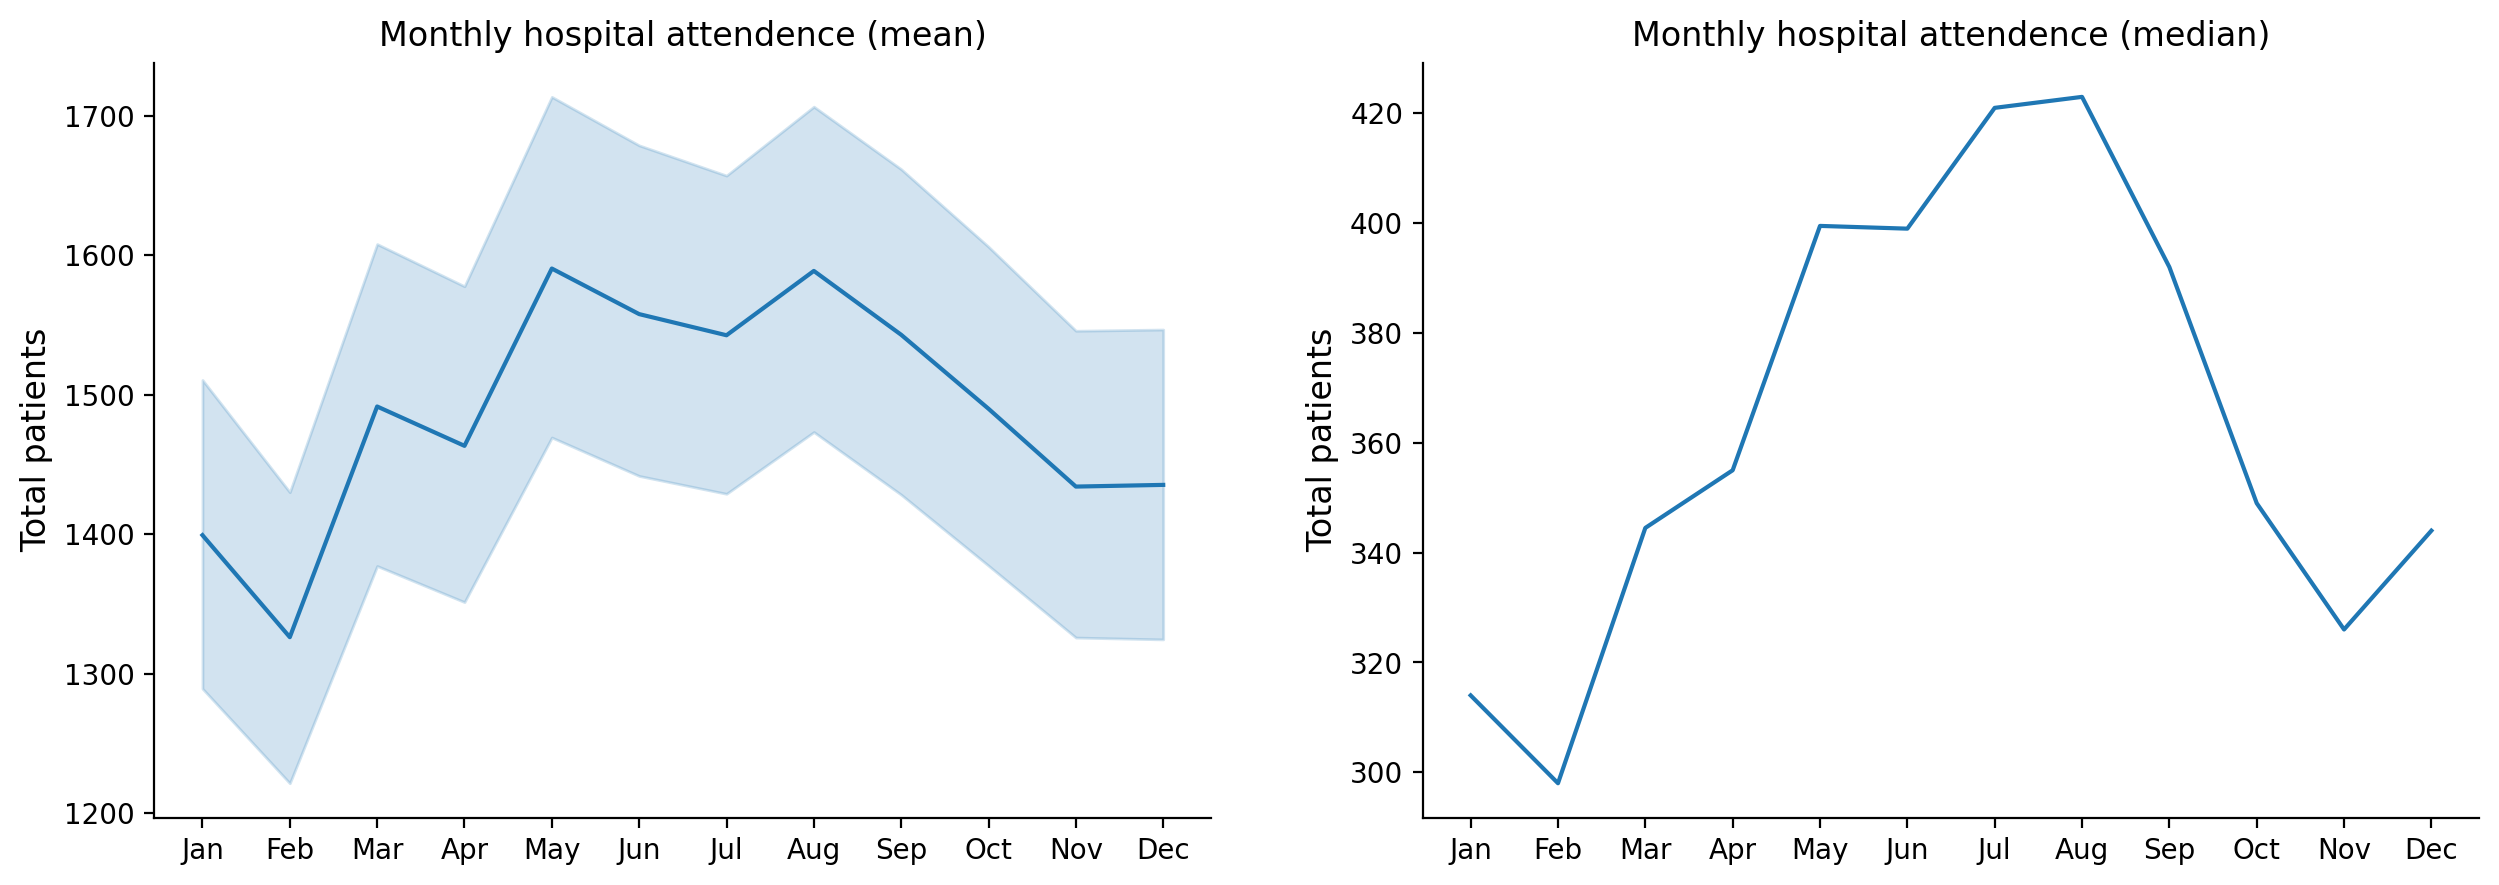

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# plot 1
sns.lineplot(data=data,
             x='month',
             y='total',
             ci=95,
             n_boot=10000,
             ax=ax1)
format_graph(ax1, mode='m', ylabel='Total patients', title='Monthly hospital attendence (mean)')

# plot 2
df = data.groupby('month').median()
sns.lineplot(data=df,
             x='month',
             y='total',
             ax=ax2)

format_graph(ax2, mode='m', ylabel='Total patients', title='Monthly hospital attendence (median)')

sns.despine(fig)

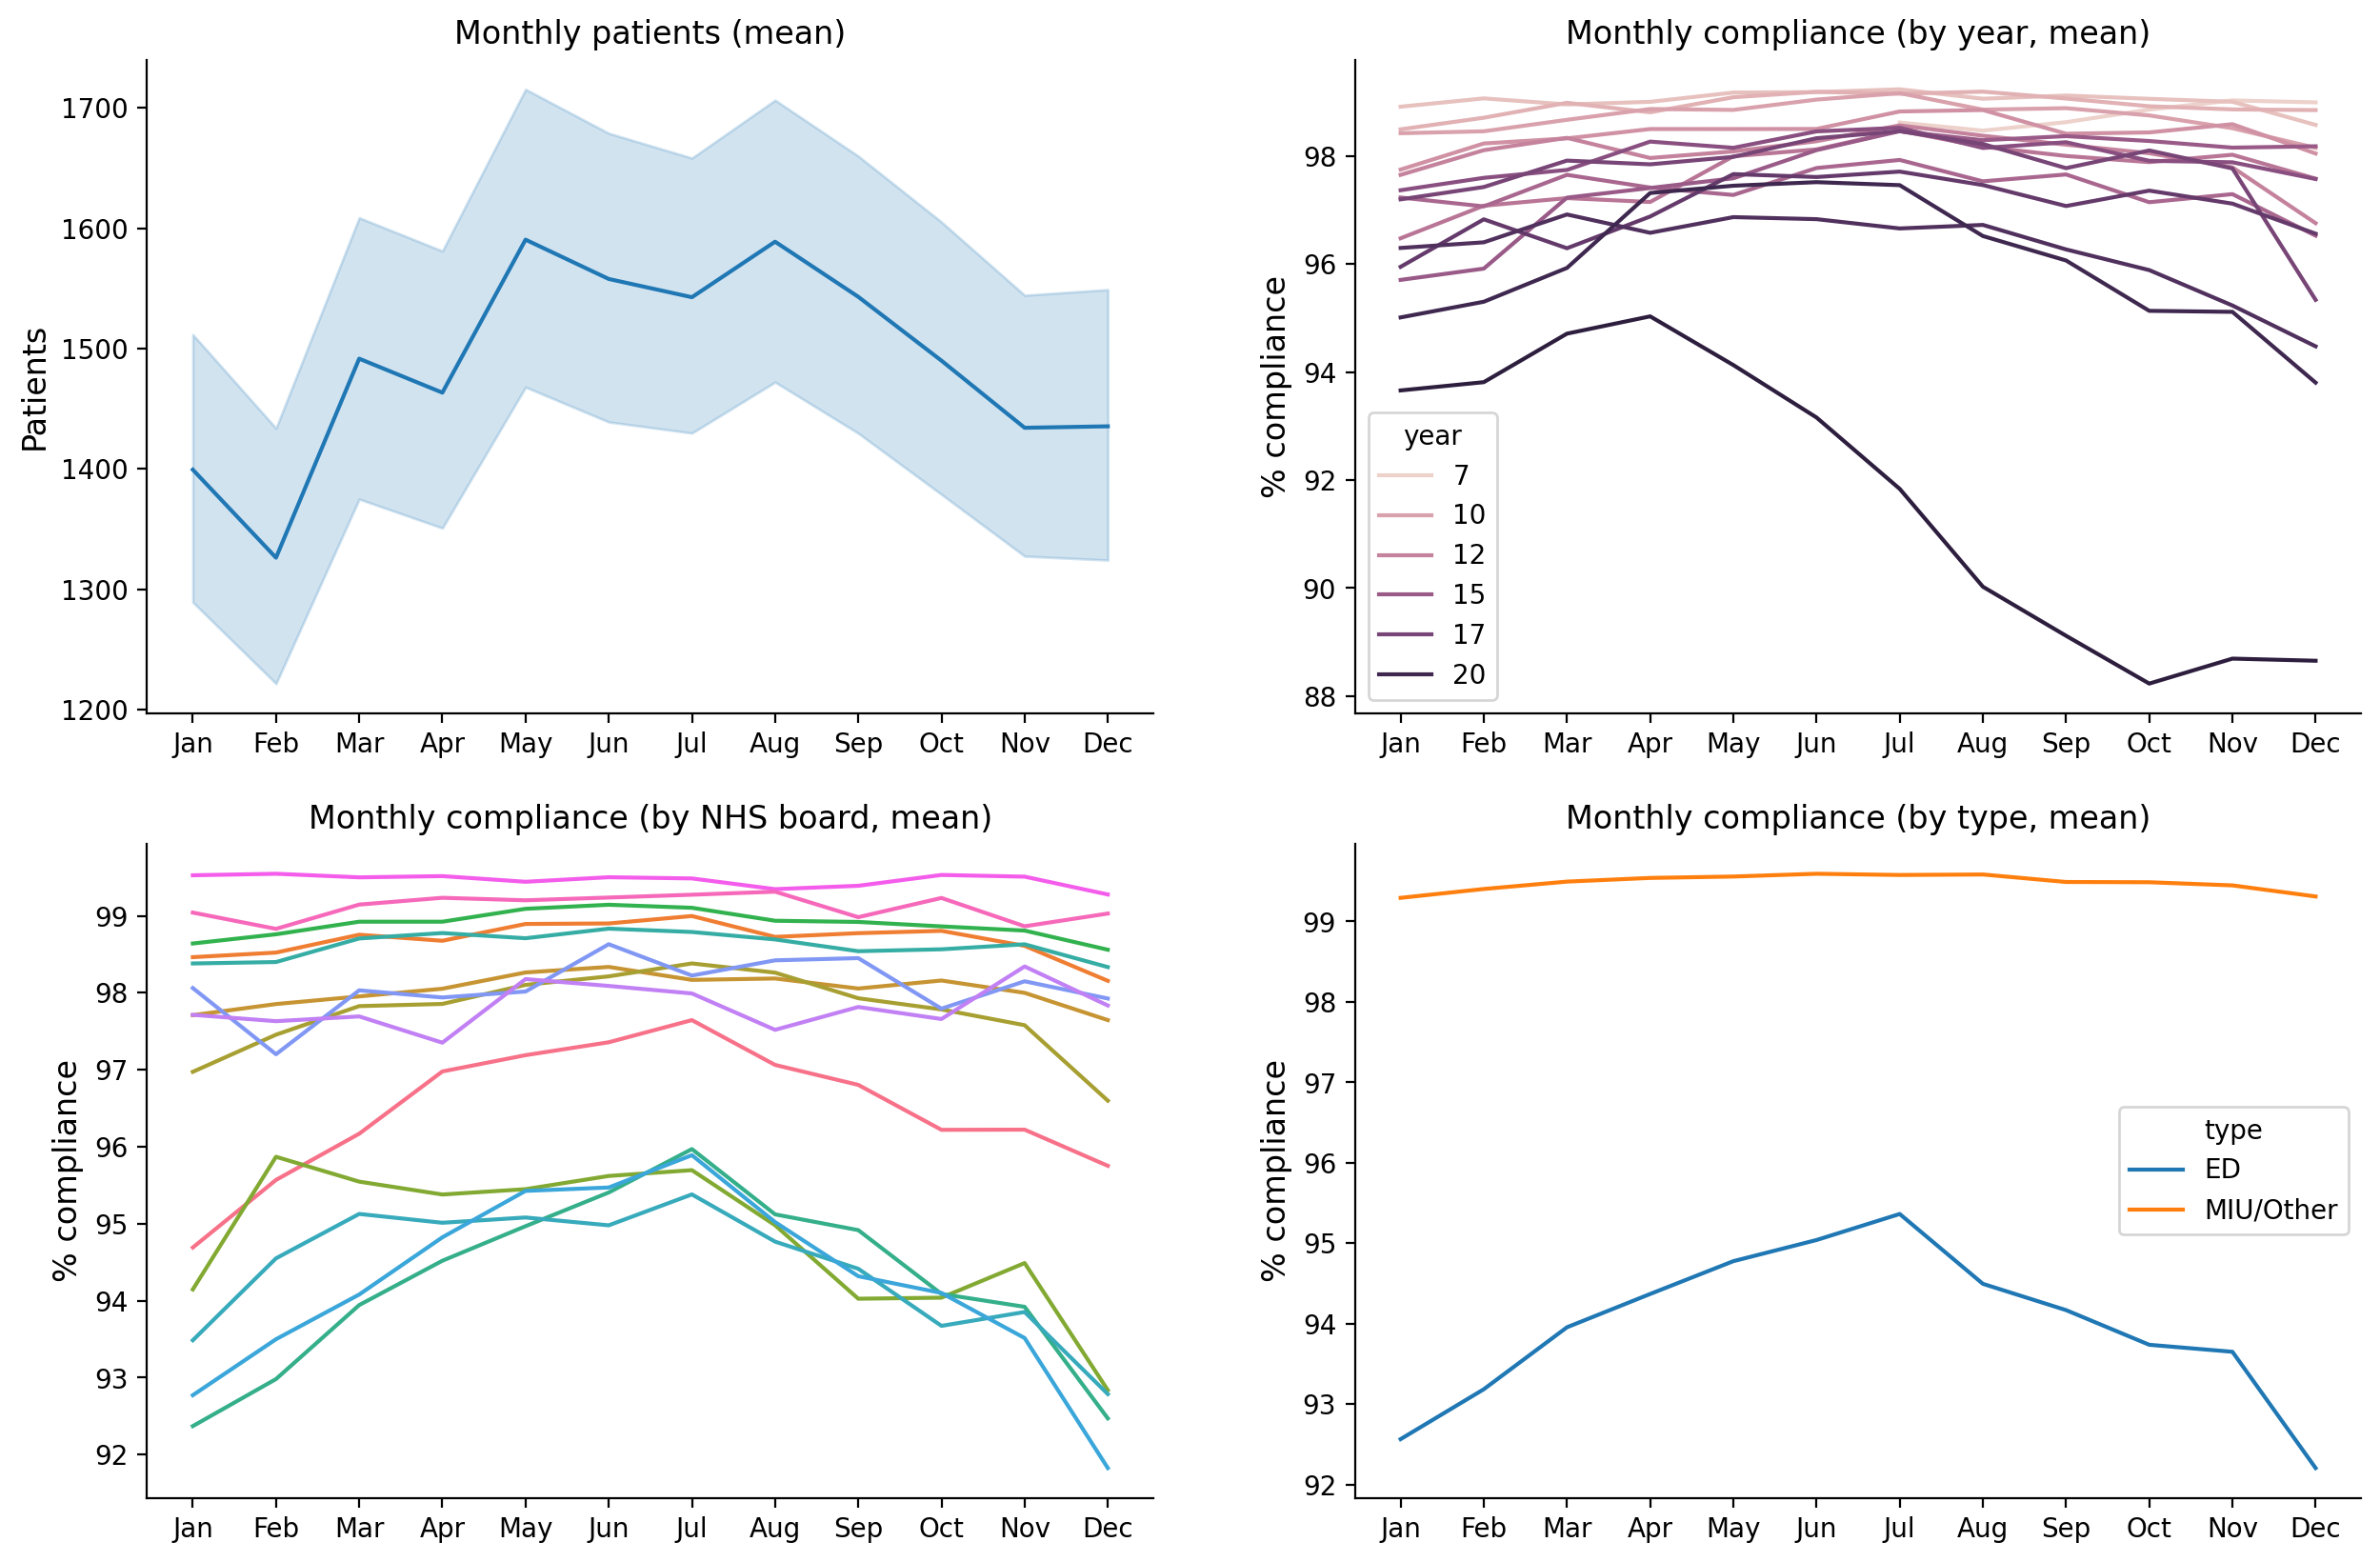

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))

# plot 1
df = data.groupby('month').mean()
sns.lineplot(data=data,
             x='month',
             y='total',
             ci=95,
             n_boot=10000,
             ax=ax1)
format_graph(ax1, mode='m', ylabel='Patients', title='Monthly patients (mean)')

# plot 2
df = data.groupby(['month', 'year']).mean()
sns.lineplot(data=df,
             x='month',
             y= 100*df['compliance_frac'],
             hue='year',
             ax=ax2)
format_graph(ax2, mode='m', ylabel='% compliance', title='Monthly compliance (by year, mean)')

# plot 3
df = data.groupby(['month', 'area']).mean()
sns.lineplot(data=df,
             x='month',
             y= 100*df['compliance_frac'],
             hue='area',
             legend=False,
             ax=ax3)
format_graph(ax3, mode='m', ylabel='% compliance', title='Monthly compliance (by NHS board, mean)')

# plot 4
df = data.groupby(['month', 'type']).mean()
sns.lineplot(data=df,
             x='month',
             y= 100*df['compliance_frac'],
             hue='type',
             ax=ax4)
format_graph(ax4, mode='m', ylabel='% compliance', title='Monthly compliance (by type, mean)')


sns.despine(fig)

# Population graphs

In [44]:
population = pd.read_csv(os.path.join(os.getcwd(), 'data','population.csv'))
population

Council area  Year  Population
0    NHS Grampian  1998      215650
1    NHS Grampian  1999      214630
2    NHS Grampian  2000      213340
3    NHS Grampian  2001      211910
4    NHS Grampian  2002      210680
..            ...   ...         ...
699   NHS Lothian  2015      178550
700   NHS Lothian  2016      180130
701   NHS Lothian  2017      181310
702   NHS Lothian  2018      182140
703   NHS Lothian  2019      183100

[704 rows x 3 columns]

100 * ols_population.params[1]=0.24%
100 * ols_patients.params[1]=1.51%


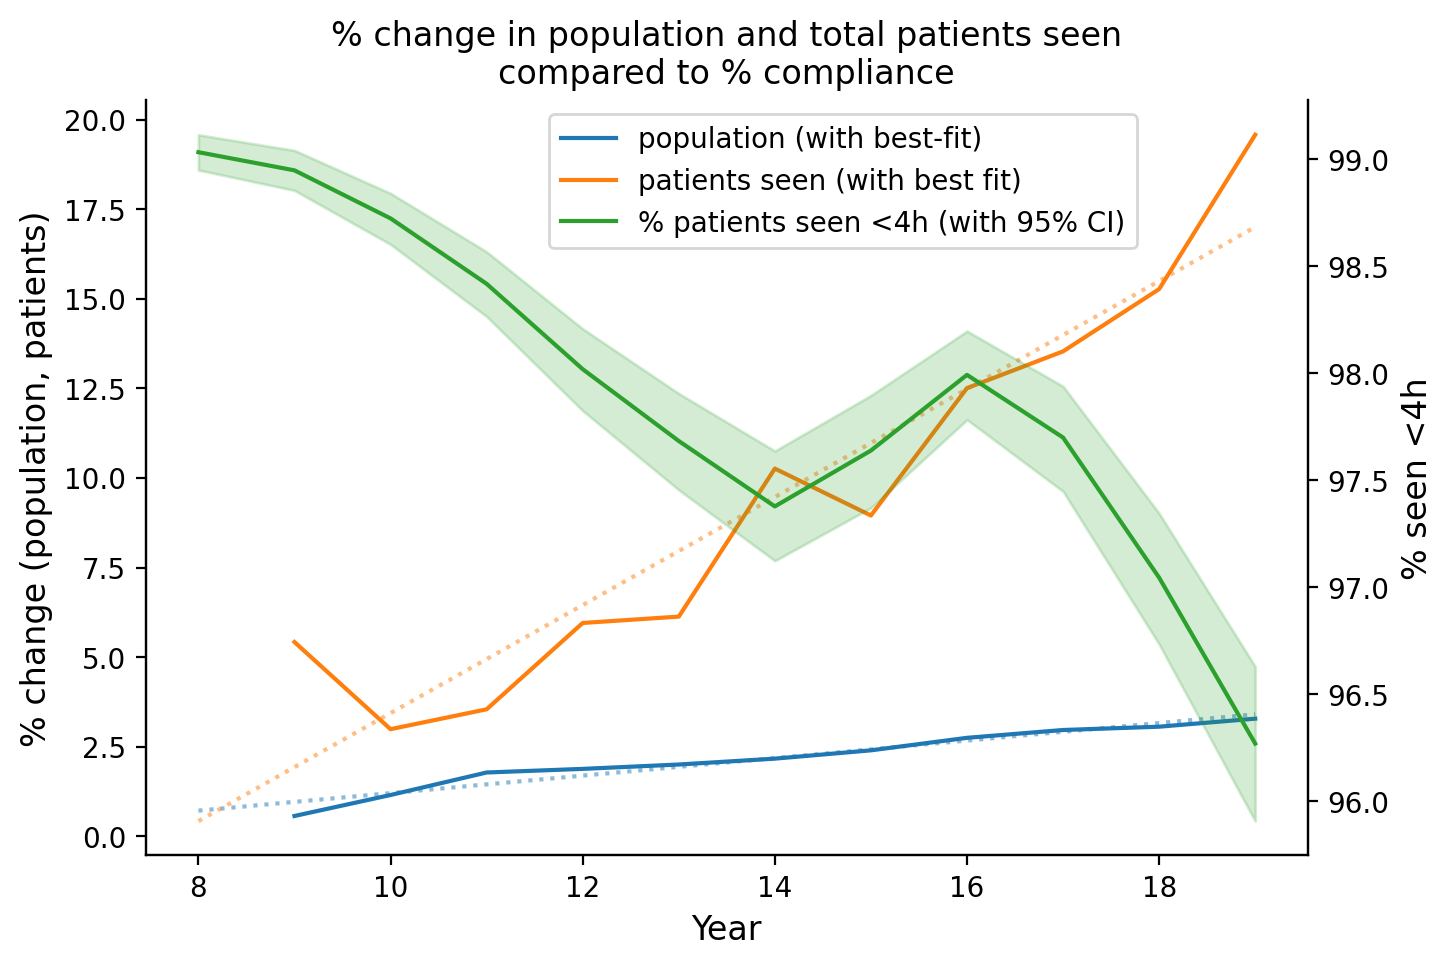

In [45]:
fig, (ax1) = plt.subplots(1, figsize=(7.5, 5))
fig.subplots_adjust(wspace=0.3)

# plot 1
# calculate cumulative change in population
df = population[population['Year'] >= 2008].groupby(['Council area', 'Year']).sum().reset_index()
df['Year'] = df['Year'].apply(lambda y: y-2000)
df['Population_delta'] = df.groupby('Council area')['Population'].pct_change()
df['Population_delta_cum'] = df.groupby('Council area')['Population_delta'].cumsum()

# calculate best-fit for cumulative change in population, join dataframes
ols_population = smf.ols('Population_delta_cum ~ Year',
                         data=df.groupby('Year').mean().reset_index()
                         ).fit()

sns.lineplot(data=df,
             x='Year',
             y=100 * df['Population_delta_cum'],
             ci=None,
             label='population (with best-fit)',
             ax=ax1)
sns.lineplot(data=df,
             x='Year',
             y=100 * ols_population.predict(df['Year']),
             ci=None,
             color=sns.color_palette()[0],
             alpha=0.5,
             linestyle='dotted',
             ax=ax1)

# calculate cumulative change in total patients
df = data[(data['year'] >= 8) & (data['year'] <= 19)].groupby(['area', 'year']).sum().reset_index()
df['patients_delta'] = df.groupby('area')['total'].pct_change()
df['patients_delta_cum'] = df.groupby('area')['patients_delta'].cumsum()

ols_patients = smf.ols('patients_delta_cum ~ year',
                       data=df.groupby('year').mean().reset_index()
                      ).fit()

sns.lineplot(data=df,
             x='year',
             y=100 * df['patients_delta_cum'],
             ci=None,
             label='patients seen (with best fit)',
             ax=ax1)
sns.lineplot(data=df,
             x='year',
             y=100 * ols_patients.predict(df['year']),
             ci=None,
             color=sns.color_palette()[1],
             alpha=0.5,
             linestyle='dotted',
             ax=ax1)

# plot 1 twin
ax2 = ax1.twinx()
df=data[(data['year'] >= 8) & (data['year'] <= 19)]
sns.lineplot(data=df,
             x='year',
             y=100*df['under4h']/df['total'],
             ci=95,
             n_boot=10000,
             color=sns.color_palette()[2],
             label='% patients seen <4h (with 95% CI)',
             legend=False,
             ax=ax2)
ax1.set_ylabel('% change (population, patients)')
ax1.set_title('% change in population and total patients seen\ncompared to % compliance')
ax2.set_ylabel('% seen <4h')

# ax1.legend(bbox_to_anchor=(0.56, 0.95))
# ax2.legend(bbox_to_anchor=(0.81, 0.925))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(loc='upper center', handles=h1 + h2, labels=l1 + l2, bbox_to_anchor=(0.6, 1))

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

print(f'{100 * ols_population.params[1]=:.2f}%\n'
      f'{100 * ols_patients.params[1]=:.2f}%')